In [130]:
!pip install Pillow
from PIL import Image

In [215]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [202]:
from keras.datasets import mnist
(X, y), (_ , _) = mnist.load_data()
X = np.reshape(X, [X.shape[0], X.shape[1]*X.shape[2]])
X.shape

(60000, 784)

In [203]:
data_matrix = X
data_matrix = data_matrix.T
data_matrix.shape

(784, 60000)

In [140]:
#mean_vector = np.mean(data_matrix, axis = 1)
#mean_vector = mean_vector.reshape(data_matrix.shape[0], 1)
def PCA(data_matrix):
    mean_v = np.zeros(shape = (784,1))
    for i in range(60000):
        mean_v = mean_v + data_matrix[:, i].reshape(784, 1)
    mean_v = mean_v/60000
    norm_data_matrix = data_matrix - mean_v
    cm = (norm_data_matrix@(norm_data_matrix.T))/60000
    e_values, e_vectors = np.linalg.eigh(cm)
    x = e_vectors.copy()
    e_values.sort()
    e_values = e_values[::-1]
    id_x = np.argsort(e_values)
    for i in range(e_vectors.shape[0]):
        e_vectors[:, i] = x[:,id_x[i]]
    return e_vectors, e_values

In [143]:
PCA(data_matrix)[0].shape

(784, 784)

In [149]:
def reducing_data(e_vectors):
    reduced_data = np.zeros(shape=(784,1000))
    for j in range(1000):
        n_x = np.zeros((784, 1))
        for i in range(154):
            w = e_vectors[:, i]
            w = w.reshape(data_matrix.shape[0], 1)
            proj = (norm_data_matrix[:,j].T).dot(w)
            x = proj*w
            n_x = n_x + x
        reduced_data[:,j] = n_x.reshape(1, 784)
    return reduced_data

In [193]:
from PIL import Image
pic = Image.fromarray(data_matrix[:,0].reshape(28, 28))
pic.show()

In [158]:
#95 % confidence interval
sum_e = PCA(data_matrix)[1].sum()
s = 0
top_e = []
for i in PCA(data_matrix)[1]:
    s = s + i
    top_e.append(i)
    if (s > 0.95*sum_e):
        print(len(top_e))
        break

154


Text(0.5, 1.0, 'Variance explained by each Principal Component')

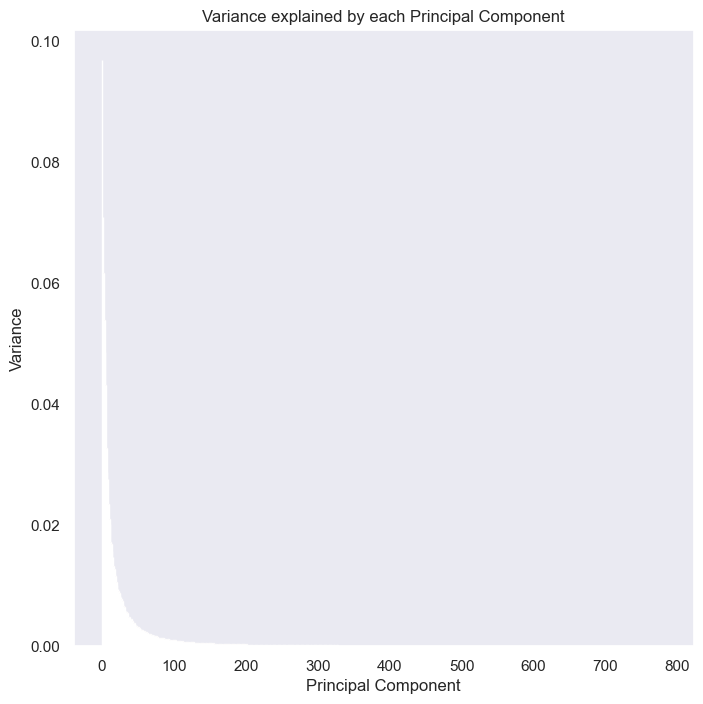

In [222]:
x_axis = np.arange(0,784,1)
e_va = PCA(data_matrix)[1]
va_c = []
for i in range(784):
    va_c.append(e_va[i]/e_va.sum())
plt.bar(x_axis, va_c, color = 'maroon')
plt.grid(False)
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.title('Variance explained by each Principal Component')

[Text(0.5, 0, 'Number of Principal Components'),
 Text(0, 0.5, 'Variance Explained in %'),
 Text(0.5, 1.0, 'Variance vs No. of Principal Components')]

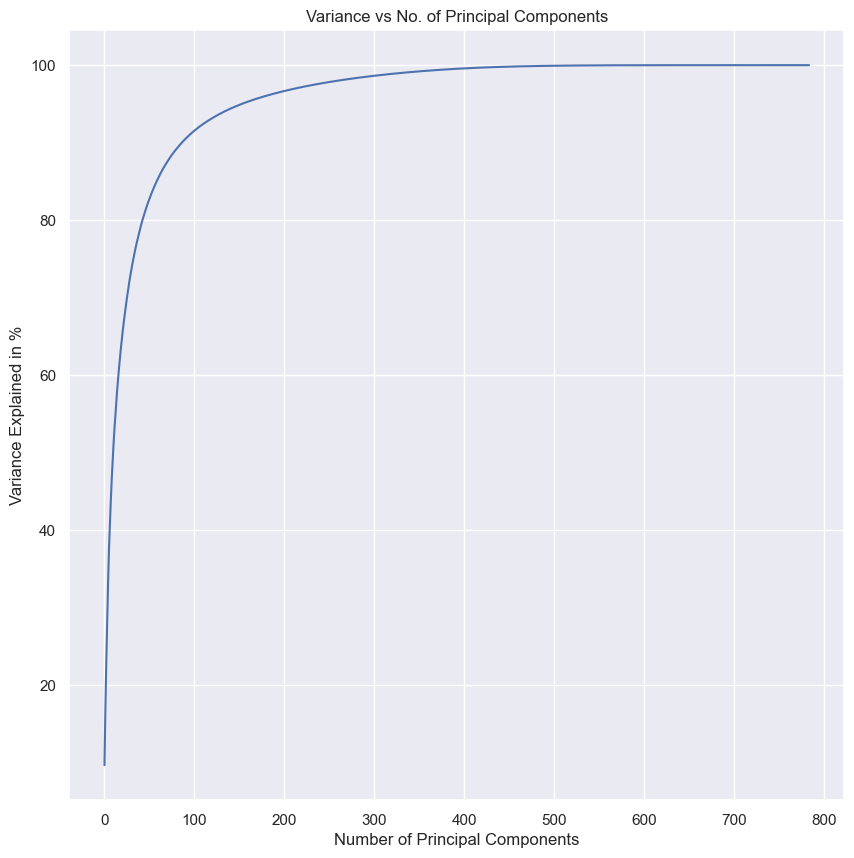

In [154]:
s = 0
per_l = []
for i in PCA(data_matrix)[1]:
    s = s + i
    per = s*100/sum_e
    per_l.append(per)
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.lineplot(x=np.arange(len(per_l)), y=per_l)
ax.set(xlabel = "Number of Principal Components", ylabel = "Variance Explained in %", title = "Variance vs No. of Principal Components")

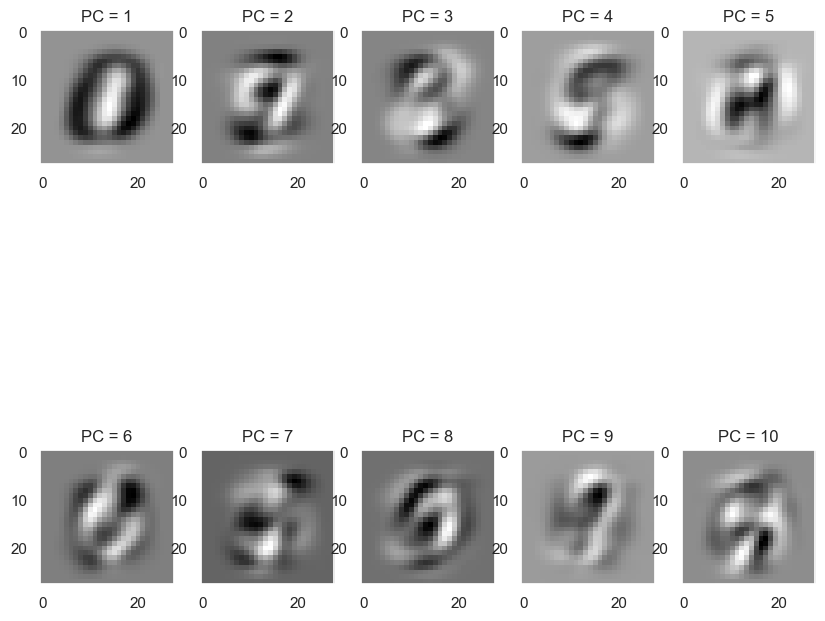

In [163]:
no_of_c = 10
for i in range(no_of_c):
    plt.subplot(2,5,i+1)
    plt.imshow(PCA(data_matrix)[0][:,i].reshape((28,28)), cmap = 'gray')
    plt.grid(False)
    plt.title('PC = {}'.format(i+1))

In [110]:
data_matrix.shape

(784, 60000)

In [174]:
def poly(x_i, x_j, d):
    return ((x_i.T)@(x_j) + 1)**d

In [175]:
def rbf(x_i, x_j, sigma):
    np.exp(-((np.linalg.norm(x_i-x_j)**2)/(2*sigma**2)))

In [209]:
n = 1000
def kernel_PCA_poly(reduced_data, d, n = 1000):
    kernel_data = reduced_data
    K = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(n):
            x_i = kernel_data[:, i]
            x_i = x_i/np.linalg.norm(x_i)
            x_j = kernel_data[:, j]
            x_j = x_j/np.linalg.norm(x_j)
            K[i][j] = ((x_i.T)@(x_j) + 1)**d
    san = K - K.mean(axis=1).reshape(n,1) - K.mean(axis=0) + K.mean()
    e1, e2 = np.linalg.eigh(san)
    beta = e2[:, n-2:n]
    beta[:,0] = beta[:,0]/((e1[n-1])**0.5)
    beta[:,1] = beta[:,1]/((e1[n-2])**0.5)
    projections = np.matmul(san,beta)
    var_ex = ((abs(e1[n-1]) + abs(e1[n-2]))*100)/np.sum(e1)
    sns.set(rc={'figure.figsize':(8,8)})
    g = sns.scatterplot(x = projections[:,0], y = projections[:,1], hue = y[0:n], palette=sns.color_palette("hls", 10))
    g.set(xlabel = 'First Component', ylabel ='Second Component', title = 'Representation of each datapoint by top 2 components using polynomial kernel with degree = {}'.format(d))
    return(plt.show(), var_ex)

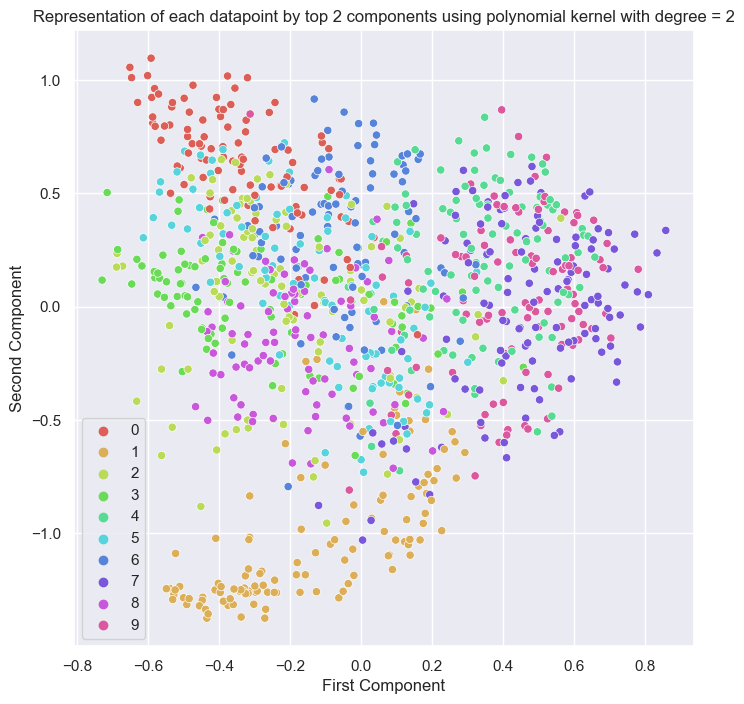

Variance explained = 13.15831390371403


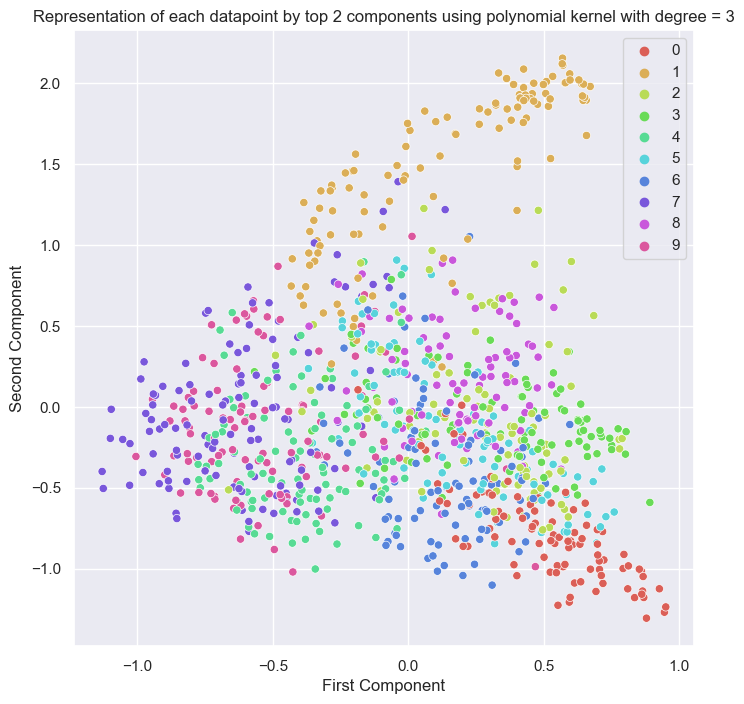

Variance explained = 9.696219508864436


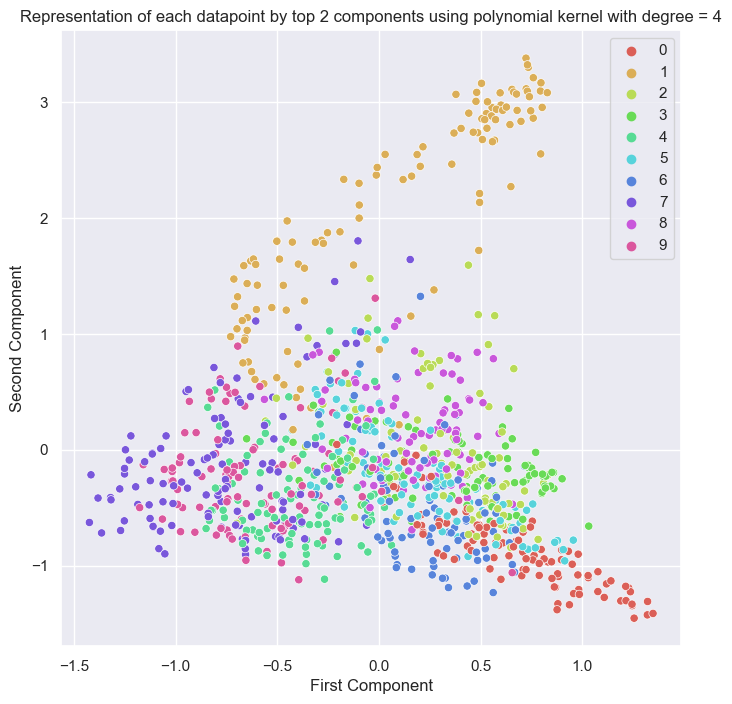

Variance explained = 7.30960795421442


In [211]:
for i in range(2,5):
    po, varia = kernel_PCA_poly(reducing_data(PCA(data_matrix)[0]), d = i)
    po
    print('Variance explained = {}'.format(varia))

In [205]:
def kernel_PCA_rbf(reduced_data, sigma, n = 1000):
    kernel_data = reduced_data
    K = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(n):
            x_i = kernel_data[:, i]
            x_i = x_i/np.linalg.norm(x_i)
            x_j = kernel_data[:, j]
            x_j = x_j/np.linalg.norm(x_j)
            K[i][j] = np.exp(-((np.linalg.norm(x_i-x_j)**2)/(2*sigma**2)))
    san = K - K.mean(axis=1).reshape(n,1) - K.mean(axis=0) + K.mean()
    e1, e2 = np.linalg.eigh(san)
    beta = e2[:, n-2:n]
    beta[:,0] = beta[:,0]/((e1[n-1])**0.5)
    beta[:,1] = beta[:,1]/((e1[n-2])**0.5)
    projections = np.matmul(san,beta)
    var_ex = ((abs(e1[n-1]) + abs(e1[n-2]))*100)/e1.sum()
    sns.set(rc={'figure.figsize':(8,8)})
    g = sns.scatterplot(x = projections[:,0], y = projections[:,1], hue = y[0:n], palette=sns.color_palette("hls", 10))
    g.set(xlabel = 'First Component', ylabel ='Second Component', title = 'Representation of each datapoint by top 2 components using Gaussian Kernel sigma = {}'.format(sigma))
    return(plt.show(), var_ex)

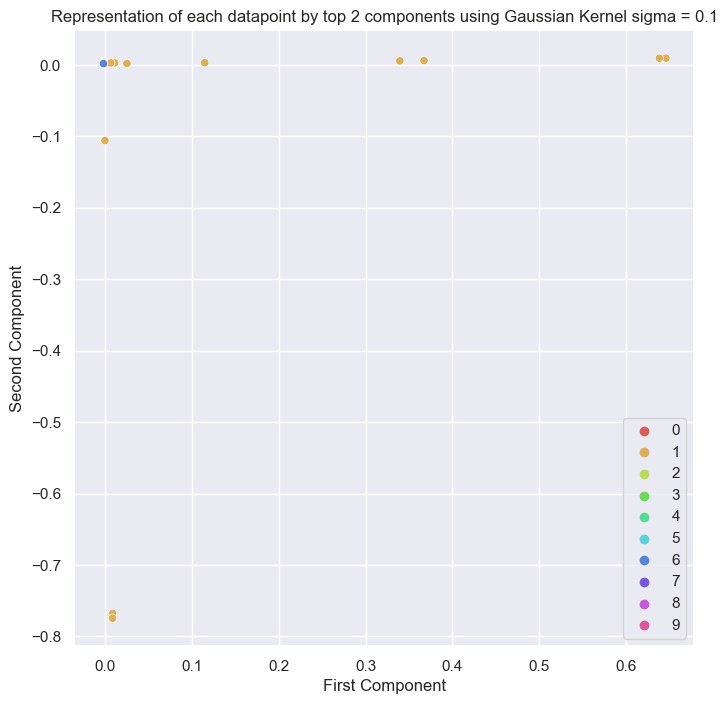

Variance explained = 0.2298101857654088


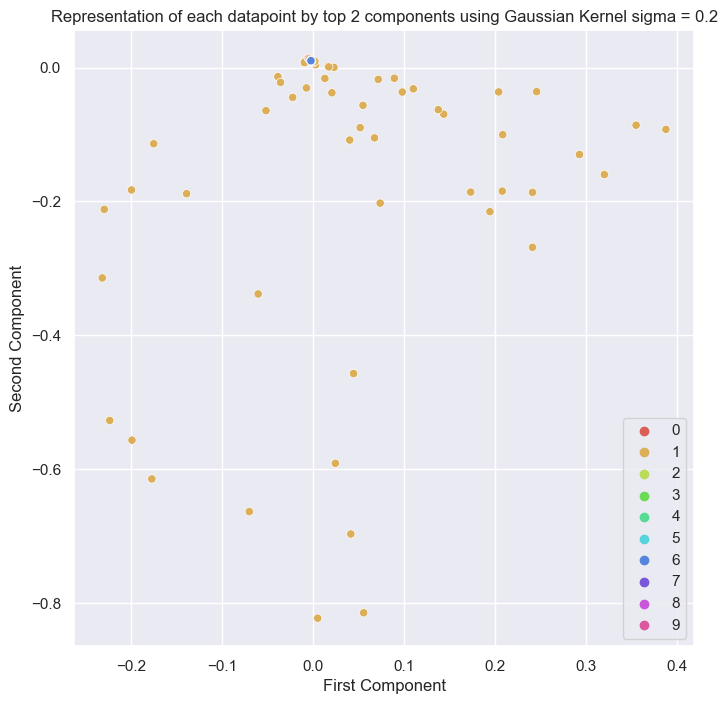

Variance explained = 0.4969945570894774


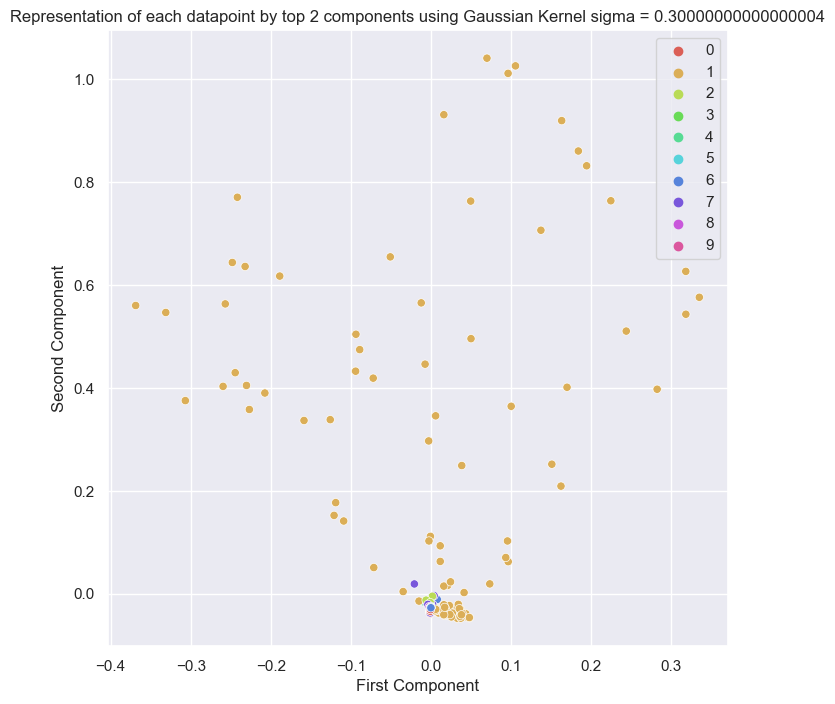

Variance explained = 1.1887628406806245


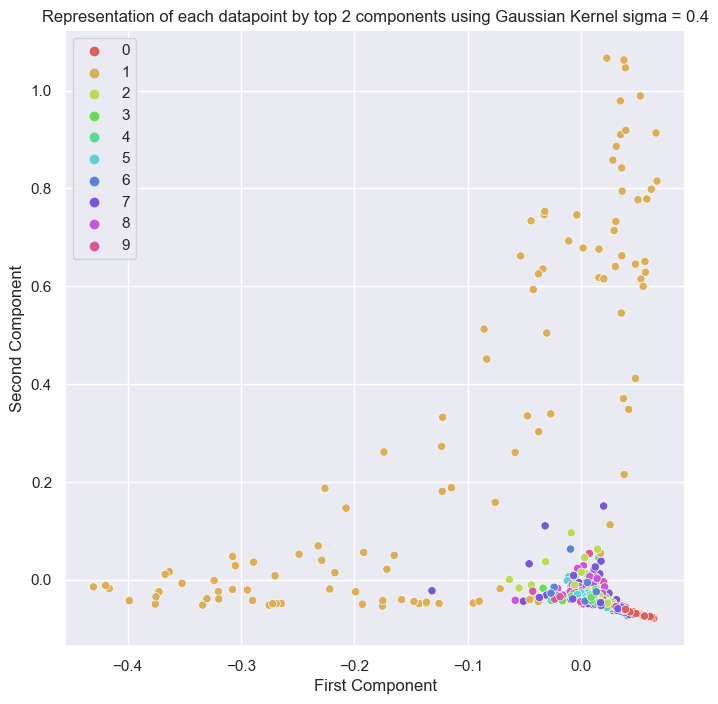

Variance explained = 2.3497077187108975


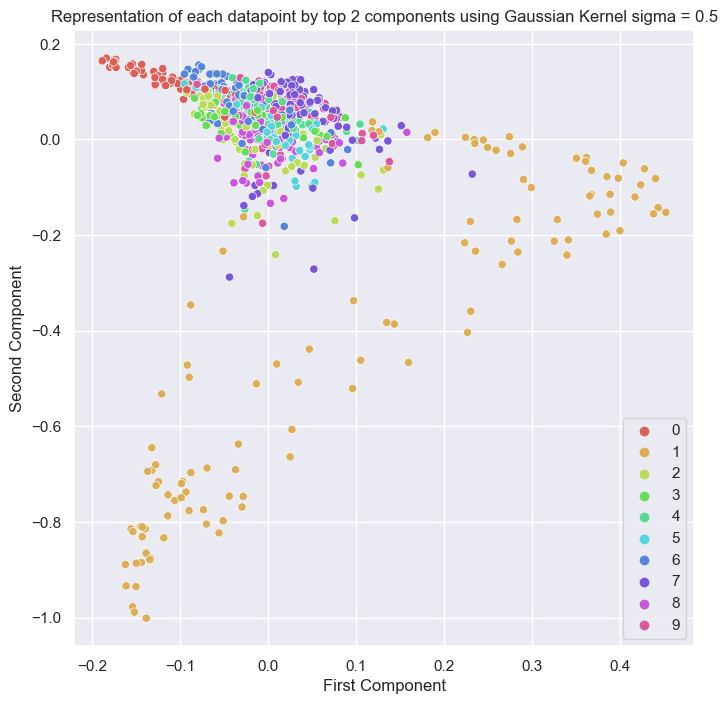

Variance explained = 3.825884777231605


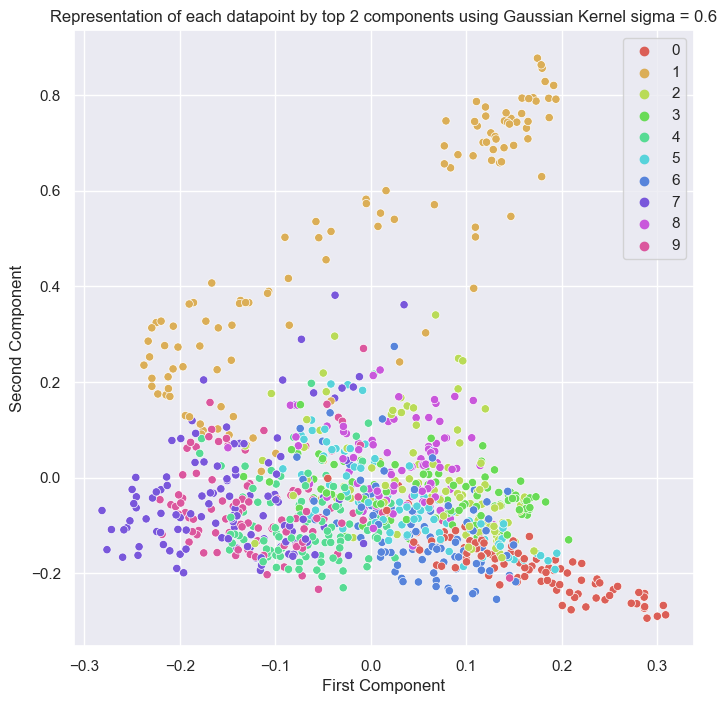

Variance explained = 5.656116897550968


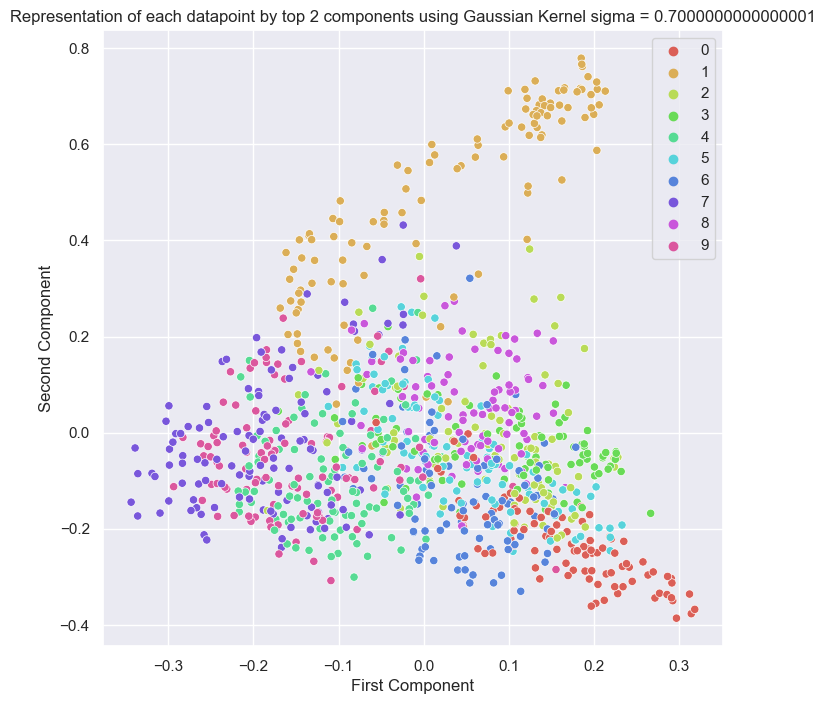

Variance explained = 7.5826342365522565


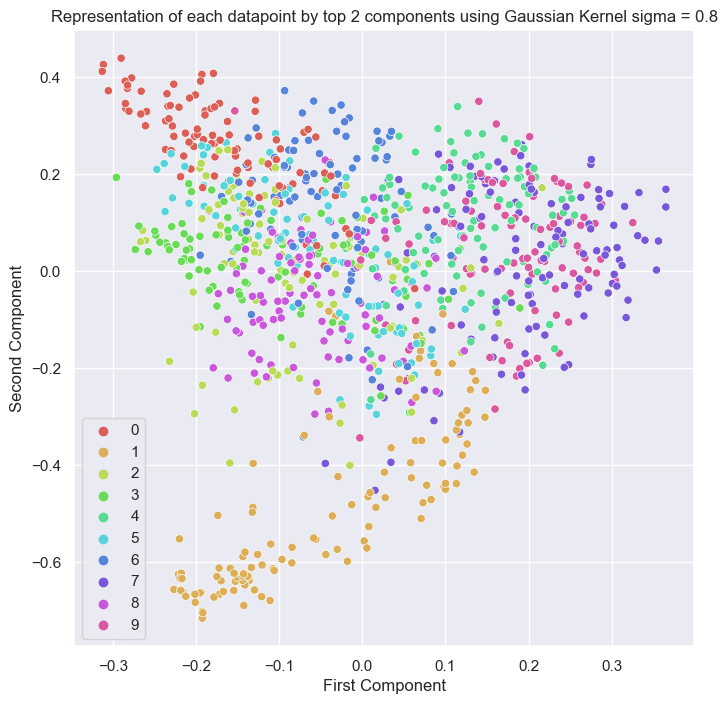

Variance explained = 9.28573808158446


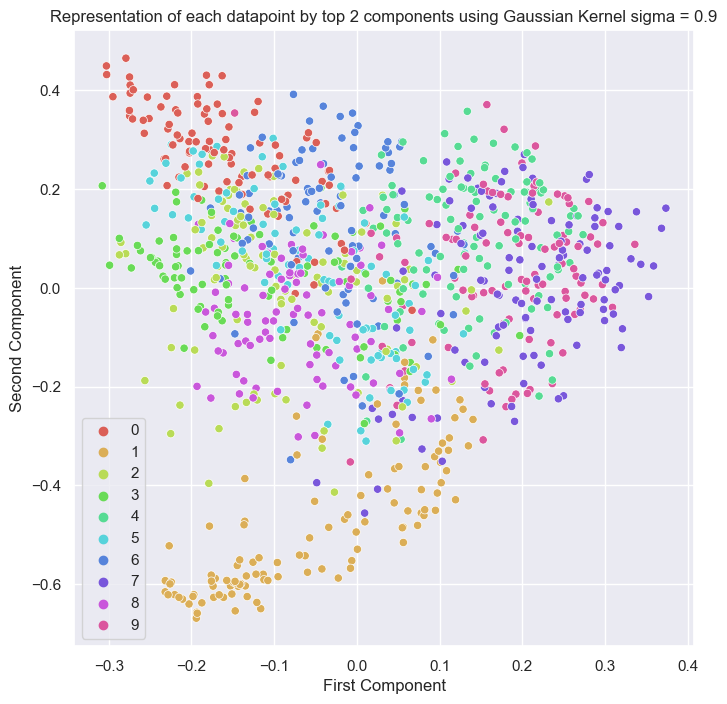

Variance explained = 10.694521510758124


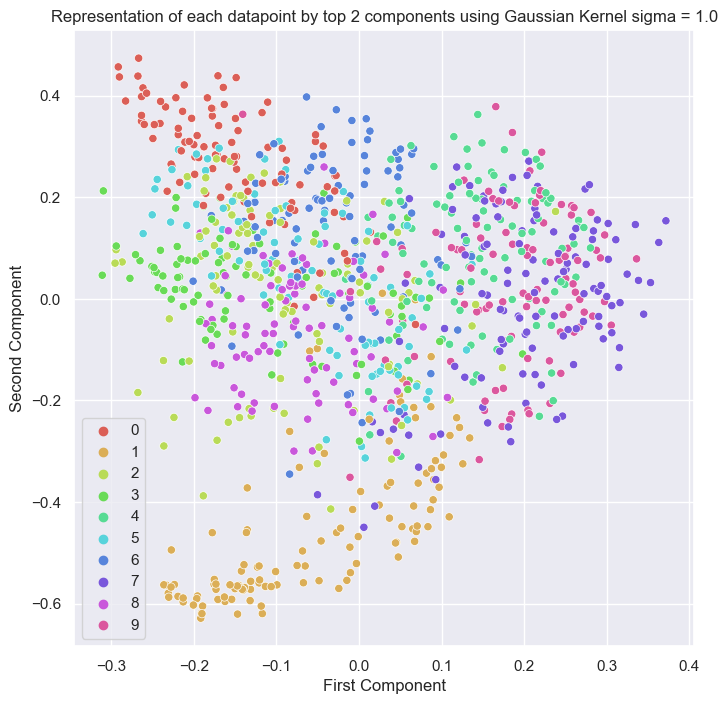

Variance explained = 11.833079353958476


In [206]:
l = np.linspace(0.1, 1, 10)
for i in l:
    plot, vari = kernel_PCA_rbf(reducing_data(PCA(data_matrix)[0]), sigma = i)
    plot
    print('Variance explained = {}'.format(vari))